# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import pickle
import torch
import numpy as np
import pandas as pd
import datetime as dt
import random
from matplotlib import pyplot as plt

from IPython.display import display, HTML
from torch.utils.data import Dataset,DataLoader,random_split

from src.dcits import DCITS
from src.utils import model_data_from_time_series,get_data_loaders_and_eval_datasets,train_model,evaluate_model,TimeSeriesDataset

In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Specify the device as the second GPU
    device = torch.device("cuda:0")
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")

In [5]:
seed=1000
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Dataset 7

In [6]:
time_series=pickle.load(open('../data/dataset7.pickle','rb'))

In [7]:
window_len=10
num_of_timeseries=5

model=DCITS(num_of_timeseries,window_len,in_ch=16,temp=0.1)
model=model.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)

In [8]:
time_series=torch.tensor(time_series)

/tmp/ipykernel_22522/2583987824.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_series=torch.tensor(time_series)


In [9]:
X,y=model_data_from_time_series(time_series,device,remove_first=1000,window_len=window_len)

In [10]:
train_one_epoch, valid_one_epoch, test_dataset=get_data_loaders_and_eval_datasets(X,y,optimizer,loss_fn)

In [11]:
model=train_model(model,train_one_epoch,valid_one_epoch,epochs=20,enable_writer=False,save_model=False)

Epoch 1/20
  Training Loss: 0.00079595
  Validation Loss: 0.00830324
Epoch 2/20
  Training Loss: 0.00053684
  Validation Loss: 0.00592379
Epoch 3/20
  Training Loss: 0.00053035
  Validation Loss: 0.00502129
Epoch 4/20
  Training Loss: 0.00045007
  Validation Loss: 0.00496962
Epoch 5/20
  Training Loss: 0.00040001
  Validation Loss: 0.00453590
Epoch 6/20
  Training Loss: 0.00042038
  Validation Loss: 0.00438534
Epoch 7/20
  Training Loss: 0.00035392
  Validation Loss: 0.00399277
Epoch 8/20
  Training Loss: 0.00036152
  Validation Loss: 0.00470856
Epoch 9/20
  Training Loss: 0.00038354
  Validation Loss: 0.00343293
Epoch 10/20
  Training Loss: 0.00037443
  Validation Loss: 0.00538644
Epoch 11/20
  Training Loss: 0.00034613
  Validation Loss: 0.00342112
Epoch 12/20
  Training Loss: 0.00032112
  Validation Loss: 0.00325248
Epoch 13/20
  Training Loss: 0.00034311
  Validation Loss: 0.00337824
Epoch 14/20
  Training Loss: 0.00035834
  Validation Loss: 0.00428641
Epoch 15/20
  Training Loss: 

In [12]:
idx = test_dataset.indices
x = test_dataset.dataset.X[idx]
y, f, c = model(x) 

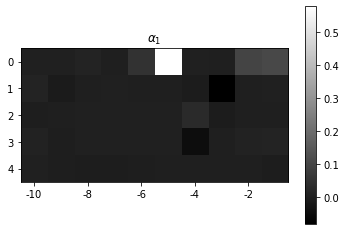

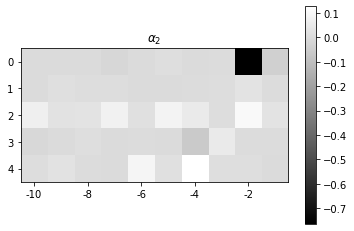

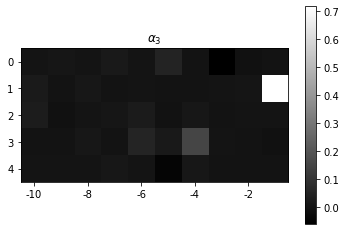

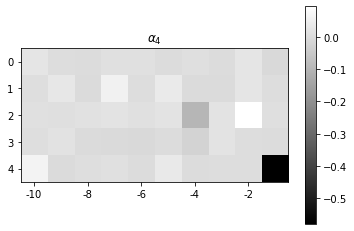

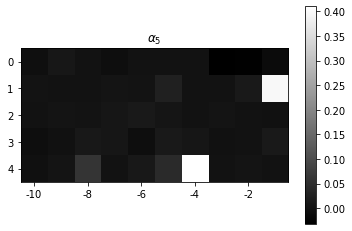

In [13]:
alpha=(f*c).mean(0).detach().cpu().numpy()
for i in range(num_of_timeseries):
    plt.imshow(alpha[i],cmap=plt.cm.binary_r)
    ax = plt.gca()
    ax.set_xticks([0, 2, 4, 6, 8])
    ax.set_xticklabels([-10, -8, -6, -4, -2])
    plt.title(rf'$\alpha_{i+1}$')
    plt.colorbar()
    plt.show()

In [14]:
# Calculate beta_tilda values
beta_tilda=(f*c).abs().mean(0).sum(2).detach().cpu().numpy()

Text(0.5, 1.0, 'Mean $\\beta$ values')

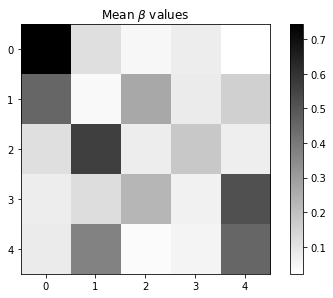

In [15]:
# Plot beta values
plt.imshow(beta_tilda/beta_tilda.sum(1,keepdims=True),cmap=plt.cm.binary)
plt.colorbar()
plt.tight_layout()
plt.title(rf'Mean $\beta$ values')

# VAR(2) Model 

We have a vector autoregressive (VAR) process of order 2 with the following form:

$$
\begin{pmatrix}
Y_{1,t} \\
Y_{2,t} \\
Y_{3,t}
\end{pmatrix} =
\begin{pmatrix}
c_1 \\
c_2 \\
c_3
\end{pmatrix} +
\begin{pmatrix}
a_{11,1} & a_{12,1} & a_{13,1} \\
a_{21,1} & a_{22,1} & a_{23,1} \\
a_{31,1} & a_{32,1} & a_{33,1}
\end{pmatrix}
\begin{pmatrix}
Y_{1,t-1} \\
Y_{2,t-1} \\
Y_{3,t-1}
\end{pmatrix} +
\begin{pmatrix}
a_{11,2} & a_{12,2} & a_{13,2} \\
a_{21,2} & a_{22,2} & a_{23,2} \\
a_{31,2} & a_{32,2} & a_{33,2}
\end{pmatrix}
\begin{pmatrix}
Y_{1,t-2} \\
Y_{2,t-2} \\
Y_{3,t-2}
\end{pmatrix} +
\begin{pmatrix}
u_{1,t} \\
u_{2,t} \\
u_{3,t}
\end{pmatrix}
$$

where:
- $Y_{1,t}$ is the first variable at time $t$,
- $Y_{2,t}$ is the second variable at time $t$,
- $Y_{3,t}$ is the third variable at time $t$,
- $c_1 = 0.1$, $c_2 = 0.05$, $c_3 = 0$ are the constants (intercepts).

The first coefficient matrix for the lag-1 terms is:

$$
\begin{pmatrix}
a_{11,1} & a_{12,1} & a_{13,1} \\
a_{21,1} & a_{22,1} & a_{23,1} \\
a_{31,1} & a_{32,1} & a_{33,1}
\end{pmatrix} =
\begin{pmatrix}
0.4 & 0.1 & 0.05 \\
0.1 & 0.4 & 0.1 \\
0.05 & 0.1 & 0.4
\end{pmatrix}
$$

The second coefficient matrix for the lag-2 terms is:

$$
\begin{pmatrix}
a_{11,2} & a_{12,2} & a_{13,2} \\
a_{21,2} & a_{22,2} & a_{23,2} \\
a_{31,2} & a_{32,2} & a_{33,2}
\end{pmatrix} =
\begin{pmatrix}
0.2 & 0.05 & 0.02 \\
0.05 & 0.2 & 0.05 \\
0.02 & 0.05 & 0.2
\end{pmatrix}
$$

The noise error terms $u_{1,t}$, $u_{2,t}$, and $u_{3,t}$ are sampled from a Gaussian distribution with variance that produces noise one-tenth of the signal. Specifically:

$$
u_{i,t} \sim \mathcal{N}(0, \sigma^2), \quad \text{where} \quad \sigma = \frac{\max(Y[:10,:])}{10}
$$

In [16]:

# Define the total number of time steps and the number of initial steps to discard
n_total_steps = 20000
n_discard_steps = 1000

# Initialize arrays to store the time series data
Y = np.zeros((n_total_steps, 3))

# Define the coefficients
c = np.array([0.1, 0.05, 0.0])

A1 = np.array([
    [0.4, 0.1, 0.05],
    [0.1, 0.4, 0.1],
    [0.05, 0.1, 0.4]
])

A2 = np.array([
    [0.2, 0.05, 0.02],
    [0.05, 0.2, 0.05],
    [0.02, 0.05, 0.2]
])

In [17]:
# Initialize the first 10 steps from N(0,1)
Y[:10, :] = np.random.normal(0, 1, (10, 3))

# Determine max absolute value of the initial signal
initial_max_signal = np.max(np.abs(Y[:10]))

# Define the noise sigma
sigma = initial_max_signal / 10

In [18]:
# Generate the time series data
for t in range(10, n_total_steps):
    Y_t_minus_1 = Y[t-1, :]
    Y_t_minus_2 = Y[t-2, :]
    Y_t_minus_3 = Y[t-3, :]
    
    Y_t = c + A1 @ Y_t_minus_1 + A2 @ Y_t_minus_2  + np.random.normal(0, sigma, 3)
    #+ A3 @ Y_t_minus_3
    Y[t, :] = Y_t

# Discard the first 100 steps
Y = Y[n_discard_steps:]

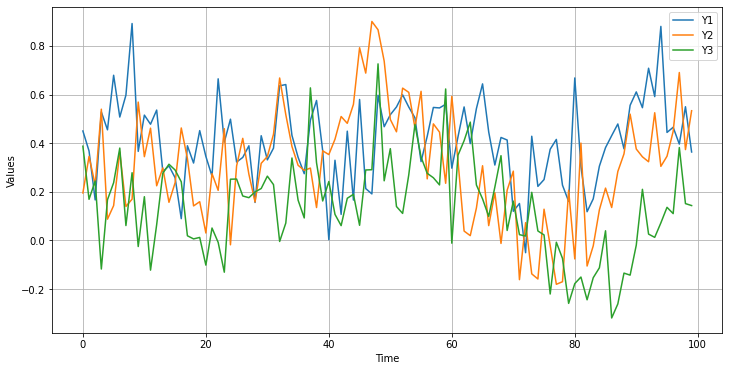

In [19]:
# Plot the first 100 steps of the time series Y1, Y2, and Y3 on one plot
plt.figure(figsize=(12, 6))

plt.plot(Y[:100, 0], label='Y1')
plt.plot(Y[:100, 1], label='Y2')
plt.plot(Y[:100, 2], label='Y3')

#plt.title('First 100 Steps of Y1, Y2, and Y3')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

In [20]:
time_series=Y.T

In [21]:
time_series=torch.tensor(time_series)

In [22]:
window_len=5
num_of_timeseries=3

model=DCITS(num_of_timeseries,window_len,in_ch=16,temp=1)
model=model.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)

In [23]:
X,y=model_data_from_time_series(time_series,device,remove_first=1000,window_len=window_len)

In [24]:
train_one_epoch, valid_one_epoch, test_dataset=get_data_loaders_and_eval_datasets(X,y,optimizer,loss_fn,batch_size=512,shuffle=False)

In [25]:
model=train_model(model,train_one_epoch,valid_one_epoch,epochs=10,enable_writer=False,save_model=False)

Epoch 1/10
  Training Loss: 0.01636972
  Validation Loss: 0.03011328
Epoch 2/10
  Training Loss: 0.01299516
  Validation Loss: 0.02601696
Epoch 3/10
  Training Loss: 0.01233061
  Validation Loss: 0.02554626
Epoch 4/10
  Training Loss: 0.01216997
  Validation Loss: 0.02526989
Epoch 5/10
  Training Loss: 0.01211572
  Validation Loss: 0.02518018
Epoch 6/10
  Training Loss: 0.01209765
  Validation Loss: 0.02518521
Epoch 7/10
  Training Loss: 0.01209347
  Validation Loss: 0.02520290
Epoch 8/10
  Training Loss: 0.01209030
  Validation Loss: 0.02522097
Epoch 9/10
  Training Loss: 0.01208664
  Validation Loss: 0.02522756
Epoch 10/10
  Training Loss: 0.01208168
  Validation Loss: 0.02522091


In [26]:
idx = test_dataset.indices
x = test_dataset.dataset.X[idx]
y, f, c = model(x)

In [27]:
alpha=np.round((f*c).mean(0).detach().cpu().numpy(),2) # For clarity we round the values

In [28]:
# Lets display learned matrix with ground truth
df_alpha = pd.DataFrame(alpha[:,:,-1], columns=[1,2,3]) # alpha[:,:,-1] coresponds to A2
df_A1 = pd.DataFrame(A1, columns=[1,2,3])


display(HTML("""
<style>
    .side-by-side {
        display: flex;
        justify-content: center;
        gap: 5rem;  /* Small space between the tables */
    }
    .dataframe th, .dataframe td {
        padding: 1rem;
        font-size: 2.5rem;
    }
</style>
"""))

display(HTML("<div class='side-by-side'>"
             "<div><h3>A1<sub>DCIts</sub></h3>" + df_alpha.to_html() + "</div>"
             "<div><h3>A1<sub>GroundTruth</sub></h3>" + df_A1.to_html() + "</div>"
             "</div>"))

,1,2,3
0,0.41,0.11,0.06
1,0.13,0.38,0.10
2,0.06,0.10,0.38
,1,2,3
0,0.40,0.1,0.05
1,0.10,0.4,0.10
2,0.05,0.1,0.40


In [29]:
# Lets display learned matrix with ground truth
df_alpha = pd.DataFrame(alpha[:,:,-2], columns=[1,2,3]) # alpha[:,:,-2] coresponds to A2
df_A2 = pd.DataFrame(A2, columns=[1,2,3])


display(HTML("""
<style>
    .side-by-side {
        display: flex;
        justify-content: center;
        gap: 5rem;  /* Small space between the tables */
    }
    .dataframe th, .dataframe td {
        padding: 1rem;
        font-size: 2.5rem;
    }
</style>
"""))

display(HTML("<div class='side-by-side'>"
             "<div><h3>A2<sub>DCIts</sub></h3>" + df_alpha.to_html() + "</div>"
             "<div><h3>A2<sub>GroundTruth</sub></h3>" + df_A2.to_html() + "</div>"
             "</div>"))

,1,2,3
0,0.19,0.05,0.00
1,0.06,0.21,0.04
2,0.03,0.06,0.21
,1,2,3
0,0.20,0.05,0.02
1,0.05,0.20,0.05
2,0.02,0.05,0.20


# Dataset 8

In [30]:
X,y=pickle.load(open('../data/dataset8.pickle','rb'))

In [31]:
X=torch.tensor(X).to(device)
y=torch.tensor(y).to(device)

In [32]:
X.shape,y.shape

(torch.Size([17800, 1, 4, 10]), torch.Size([17800, 4]))

In [33]:
num_of_timeseries=4

model=DCITS(num_of_timeseries,10,in_ch=16,temp=0.1)
model=model.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)

In [34]:
train_epoch, valid_epoch, test_dataset=get_data_loaders_and_eval_datasets(X,y,optimizer,loss_fn,batch_size=64)

In [35]:
model=train_model(model,train_epoch,valid_epoch,epochs=10,enable_writer=False,save_model=False)

Epoch 1/10
  Training Loss: 0.00152054
  Validation Loss: 0.03250960
Epoch 2/10
  Training Loss: 0.00160707
  Validation Loss: 0.02895358
Epoch 3/10
  Training Loss: 0.00133751
  Validation Loss: 0.03070450
Epoch 4/10
  Training Loss: 0.00161053
  Validation Loss: 0.02553642
Epoch 5/10
  Training Loss: 0.00087097
  Validation Loss: 0.02471776
Epoch 6/10
  Training Loss: 0.00112979
  Validation Loss: 0.02179676
Epoch 7/10
  Training Loss: 0.00143983
  Validation Loss: 0.02426271
Epoch 8/10
  Training Loss: 0.00121104
  Validation Loss: 0.02916986
Epoch 9/10
  Training Loss: 0.00092428
  Validation Loss: 0.02070871
Epoch 10/10
  Training Loss: 0.00144926
  Validation Loss: 0.02669305


In [36]:
idx = test_dataset.indices
x = test_dataset.dataset.X[idx]
_, f, c = model(x) 

alpha=(f*c).detach().cpu().numpy()
x=x.detach().cpu().numpy()
y=y.detach().cpu().numpy()

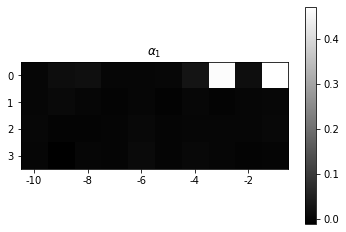

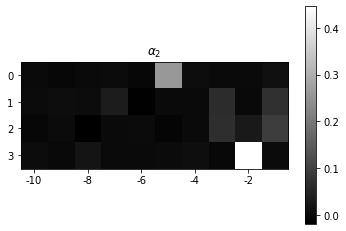

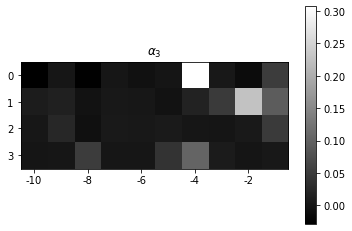

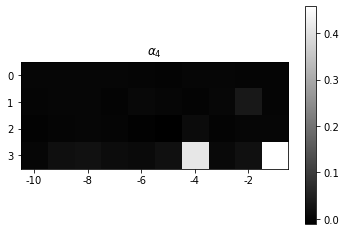

In [37]:
# We can plot average alpha values
alpha_plot=alpha.mean(0)
for i in range(num_of_timeseries):
    plt.imshow(alpha_plot[i],cmap=plt.cm.binary_r)
    ax = plt.gca()
    ax.set_xticks([0, 2, 4, 6, 8])
    ax.set_xticklabels([-10, -8, -6, -4, -2])
    plt.title(rf'$\alpha_{i+1}$')
    plt.colorbar()
    plt.show()

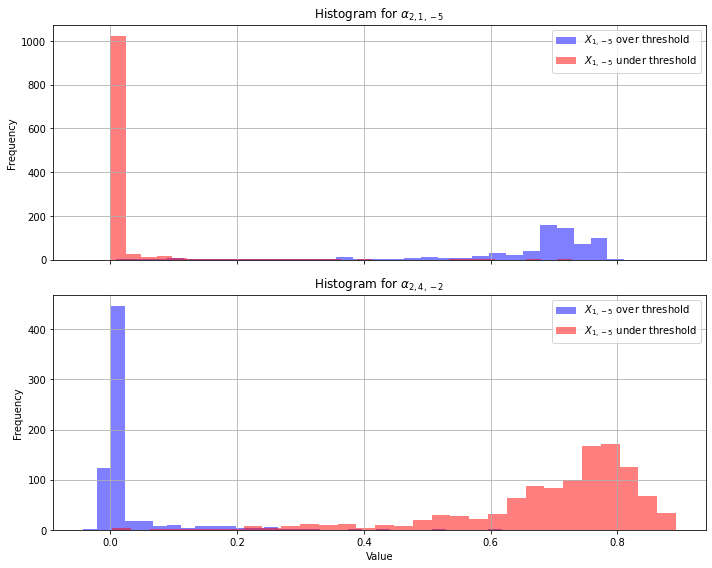

In [38]:
# Apply the condition for when X_{1,-5} is greater than 0.5 and less than or equal to 0.5
condition_greater = x[:,0,0,-5] > 0.5
condition_lesser = x[:,0,0,-5] <= 0.5

# Data for the first histogram
alpha21_greater = alpha[:,1,0,-5][condition_greater]
alpha21_lesser = alpha[:,1,0,-5][condition_lesser]

# Data for the second histogram
alpha24_greater = alpha[:,1,3,-2][condition_greater]
alpha24_lesser = alpha[:,1,3,-2][condition_lesser]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.hist(alpha21_greater, bins=30, alpha=0.5, label=r'$X_{1,-5}$ over threshold', color='blue')
ax1.hist(alpha21_lesser, bins=30, alpha=0.5, label='$X_{1,-5}$ under threshold', color='red')
ax1.set_ylabel('Frequency')
ax1.set_title(r'Histogram for $\alpha_{2,1,-5}$')
ax1.legend(loc='upper right')
ax1.grid(True)

ax2.hist(alpha24_greater, bins=30, alpha=0.5, label='$X_{1,-5}$ over threshold', color='blue')
ax2.hist(alpha24_lesser, bins=30, alpha=0.5, label='$X_{1,-5}$ under threshold', color='red')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.set_title(r'Histogram for $\alpha_{2,4,-2}$')
ax2.legend(loc='upper right')
ax2.grid(True)

fig.tight_layout()
